# Given

Two datasets - unlabelled and a validation:

![dataset](Lab2_data_snapshot.png)

# Find

Create a model and identify anomalies, by performing these steps:

* Build a gaussian distribution for each feature. Plot contours.
* Compute multivariate probability
* Compute threshold $\epsilon$
* Classify anomalies and show them on a plot

# Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Load data

In [2]:
x_train = np.load("Lab2_data_x.npy") # unlabeled set

# to select a threshold and determine anomalous vs normal examples
x_val = np.load("Lab2_data_x_val.npy")
y_val = np.load("Lab2_data_y_val.npy")

"Shapes are ", x_train.shape, x_val.shape, y_val.shape

('Shapes are ', (307, 2), (307, 2), (307,))

Comute Mean and Variance
$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_{i,j}$$
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_{i,j} - \mu_i)^2$$

In [3]:
def features_mean_stdev(data):

    id = 0
    feature_mean_stdev = {}

    for feature in range(data.shape[1]):

        feature_set = data[:,feature]
        mean = np.mean(feature_set)
        stdev = np.std(feature_set)

        feature_mean_stdev[id] = [mean, stdev]
        id += 1
        
    return feature_mean_stdev

Compute gaussian:
   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

In [4]:
def compute_gaussian(feature, mean, stdev):

    variance = stdev**2

    exponent = np.exp(-((feature-mean)**2)/(2 * variance))
    gaus_values = exponent / np.sqrt(2 * np.pi * variance)

    return gaus_values

### Compute multivariate gaussian

$$\prod_{j=1}^{n} p(x_j, \mu_j, \sigma^2_j)$$


In [5]:
def multivariate_gaussian(x, feature_mean_stdev):

    p = np.ones(shape=x.shape[0])

    for feature in range(x.shape[1]):

        mean = feature_mean_stdev[feature][0]
        stdev = feature_mean_stdev[feature][1]

        p *= compute_gaussian(x[:,feature], mean, stdev)

    return p

Plot feature gaussians

Text(0.5, 0, 'Values')

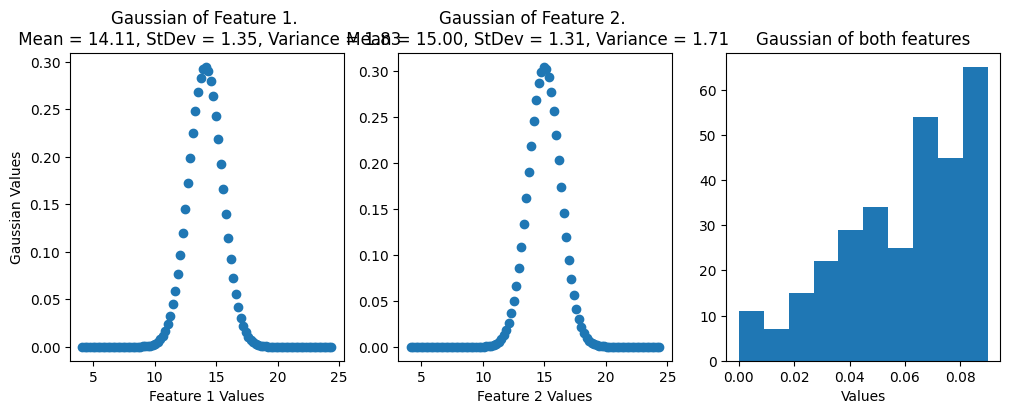

In [6]:
feature_mean_stdev = features_mean_stdev(x_train)

mean1, stdev1 = feature_mean_stdev[0]
mean2, stdev2 = feature_mean_stdev[1]

ox = np.linspace(np.min(x_train), np.max(x_train), 100)
gaussian1 = [compute_gaussian(x, mean1, stdev1) for x in ox]
gaussian2 = [compute_gaussian(x, mean2, stdev2) for x in ox]
gaussian =  multivariate_gaussian(x_train, feature_mean_stdev)

fig, ax = plt.subplots(1, 3, figsize=(12,4))

# first subplot
ax[0].scatter(ox, gaussian1)
ax[0].set_title(f"Gaussian of Feature 1. \n Mean = {'{:.2f}'.format(mean1)}, StDev = {'{:.2f}'.format(stdev1)}, Variance = {'{:.2f}'.format(stdev1**2)}")
ax[0].set_xlabel("Feature 1 Values")
ax[0].set_ylabel("Gaussian Values")

# second subplot
ax[1].scatter(ox, gaussian2)
ax[1].set_title(f"Gaussian of Feature 2. \n Mean = {'{:.2f}'.format(mean2)}, StDev = {'{:.2f}'.format(stdev2)}, Variance = {'{:.2f}'.format(stdev2**2)}")
ax[1].set_xlabel("Feature 2 Values")

# third subplot
ax[2].hist(gaussian)
ax[2].set_title(f"Gaussian of both features")
ax[2].set_xlabel("Values")

Plot confidence regions

Text(0, 0.5, 'Second feature')

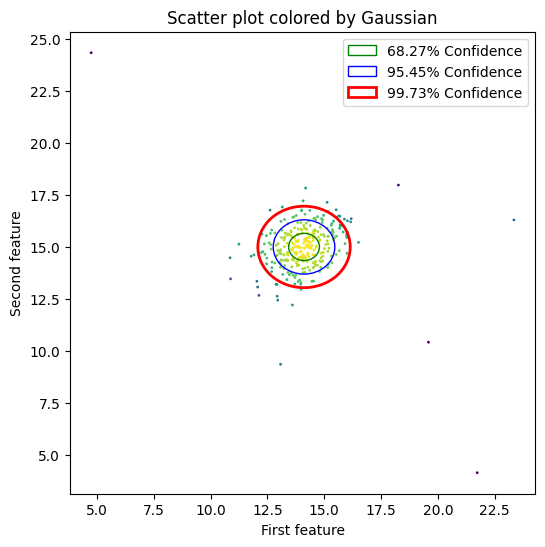

In [7]:
import matplotlib.patches as plt_patches 

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x_train[:,0], x_train[:,1], s=1, c=
           compute_gaussian(x_train[:,0], mean1, stdev1) + 
           compute_gaussian(x_train[:,1], mean2, stdev2))

# Ellipses to represent confidence intervals
ellipse1 = plt_patches.Ellipse(xy = (mean1, mean2), width=stdev1, height = stdev2,
                               edgecolor='green', fill=False)
ellipse2 = plt_patches.Ellipse(xy = (mean1, mean2), width=2*stdev1, height = 2*stdev2,
                               edgecolor='blue', fill=False)
ellipse3 = plt_patches.Ellipse(xy = (mean1, mean2), width=3*stdev1, height = 3*stdev2,
                               edgecolor='red', lw=2, fill=False)
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.add_patch(ellipse3)

ax.legend([ellipse1, ellipse2, ellipse3],
          ['68.27% Confidence', '95.45% Confidence', '99.73% Confidence'])

plt.title("Scatter plot colored by Gaussian")
plt.xlabel("First feature")
plt.ylabel("Second feature")

### Select $\epsilon$ based on F1 score

$$\begin{aligned}
precision&=&\frac{tp}{tp+fp}\\
reccall&=&\frac{tp}{tp+fn},
\end{aligned}$$

* $tp$ is the number of true positives prediction = anomaly and y_val = anomaly.
* $fp$ is the number of false positives: prediction = anomaly and y_val != anomaly.
* $fn$ is the number of false negatives: prediction != anomaly and y_val = anomaly.

$$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

In [8]:
def f1_score(y_val, gaussian):

    min_e = np.min(gaussian)
    max_e = np.max(gaussian)

    best_f1_score = 0
    best_epsilon = 0

    step = (max_e - min_e) / 1000

    for epsilon in np.arange(min_e, max_e, step):

        prediction = gaussian <= epsilon

        true_positive = np.sum((y_val==True) & (prediction==True))
        false_positive = np.sum((y_val==False) & (prediction==True))
        false_negative = np.sum((y_val==True) & (prediction==False))

        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)

        f1_score = 2 * precision * recall / (precision + recall)

        if f1_score>best_f1_score:
            best_epsilon = epsilon
            best_f1_score = f1_score

    return best_epsilon, best_f1_score

# Answer

In [9]:
gaussian = multivariate_gaussian(x_val, feature_mean_stdev)

best_epsilon, best_f1_score = f1_score(y_val, gaussian)
print(f"Error = {best_epsilon}")
print(f"F1 score = {best_f1_score}")

Error = 8.990852779269493e-05
F1 score = 0.8750000000000001


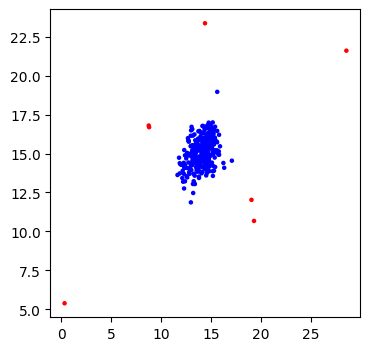

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
prediction = gaussian < best_epsilon
colors = ["red" if pred else "blue" for pred in prediction]
ax.scatter(x_val[:,0], x_val[:,1], c=colors, s=5)